##### Copyright 2018 The TensorFlow Authors.

In [62]:
// Licensed under the Apache License, Version 2.0 (the "License");
// you may not use this file except in compliance with the License.
// You may obtain a copy of the License at
//
// https://www.apache.org/licenses/LICENSE-2.0
//
// Unless required by applicable law or agreed to in writing, software
// distributed under the License is distributed on an "AS IS" BASIS,
// WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
// See the License for the specific language governing permissions and
// limitations under the License.

## Swift for TensorFlow is a work-in-progress

Swift for TensorFlow is still a work-in-progress. If you modify the code in this tutorial, you will frequently get unexpected error messages and kernel crashes. Restarting the kernel might occasionally help (Kernel > Restart in the Jupyter toolbar).

We are working on stabilizing the compiler. You can help us by filing bugs on https://bugs.swift.org (set the "Component" field to "Swift for TensorFlow") or by emailing the swift@tensorflow.org mailing list when you encounter unexpected error messages and kernel crashes.

# Swift for TensorFlow: walkthrough

This guide introduces Swift for TensorFlow by using Swift for TensorFlow to build a machine learning model that categorizes iris flowers by species. It uses Swift for TensorFlow to:
1. Build a model,
2. Train this model on example data, and
3. Use the model to make predictions about unknown data.

This guide is a Swift port of the [TensorFlow custom training walkthrough](https://www.tensorflow.org/tutorials/eager/custom_training_walkthrough).

## TensorFlow programming

This guide uses these high-level Swift for TensorFlow concepts:

* Import data with the Datasets API.
* Build models and layers using Swift abstractions.
* Use Python libraries using Swift's Python interoperability when pure Swift libraries are not available.

This tutorial is structured like many TensorFlow programs:

1. Import and parse the data sets.
2. Select the type of model.
3. Train the model.
4. Evaluate the model's effectiveness.
5. Use the trained model to make predictions.

## Setup program

### Configure imports

Import TensorFlow and some useful Python modules.

In [63]:
import TensorFlow

import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")

## The iris classification problem

Imagine you are a botanist seeking an automated way to categorize each iris flower you find. Machine learning provides many algorithms to classify flowers statistically. For instance, a sophisticated machine learning program could classify flowers based on photographs. Our ambitions are more modest—we're going to classify iris flowers based on the length and width measurements of their [sepals](https://en.wikipedia.org/wiki/Sepal) and [petals](https://en.wikipedia.org/wiki/Petal).

The Iris genus entails about 300 species, but our program will only classify the following three:

* Iris setosa
* Iris virginica
* Iris versicolor

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/images/iris_three_species.jpg"
         alt="Petal geometry compared for three iris species: Iris setosa, Iris virginica, and Iris versicolor">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://commons.wikimedia.org/w/index.php?curid=170298">Iris setosa</a> (by <a href="https://commons.wikimedia.org/wiki/User:Radomil">Radomil</a>, CC BY-SA 3.0), <a href="https://commons.wikimedia.org/w/index.php?curid=248095">Iris versicolor</a>, (by <a href="https://commons.wikimedia.org/wiki/User:Dlanglois">Dlanglois</a>, CC BY-SA 3.0), and <a href="https://www.flickr.com/photos/33397993@N05/3352169862">Iris virginica</a> (by <a href="https://www.flickr.com/photos/33397993@N05">Frank Mayfield</a>, CC BY-SA 2.0).<br/>&nbsp;
  </td></tr>
</table>

Fortunately, someone has already created a [data set of 120 iris flowers](https://en.wikipedia.org/wiki/Iris_flower_data_set) with the sepal and petal measurements. This is a classic dataset that is popular for beginner machine learning classification problems.

## Import and parse the training dataset

Download the dataset file and convert it into a structure that can be used by this Swift program.

### Download the dataset

Download the training dataset file from http://download.tensorflow.org/data/iris_training.csv. We use a Python library to demonstrate Swift's Python interoperability. Swift's Python interoperability makes it easy and natural to import and use Python libraries from Swift code.

In [64]:
let urllib = Python.import("urllib")
let downloadResult = urllib.urlretrieve("http://download.tensorflow.org/data/iris_training.csv",
                                        "iris_training.csv")
let trainDataFilename = String(downloadResult[0])!
trainDataFilename

"iris_training.csv"


### Inspect the data

This dataset, `iris_training.csv`, is a plain text file that stores tabular data formatted as comma-separated values (CSV). Let's look a the first 5 entries.

In [65]:
let f = Python.open(trainDataFilename)
for _ in 0..<5 {
    print(Python.next(f).strip())
}
f.close()

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


None


From this view of the dataset, notice the following:

1. The first line is a header containing information about the dataset:
  * There are 120 total examples. Each example has four features and one of three possible label names. 
2. Subsequent rows are data records, one *[example](https://developers.google.com/machine-learning/glossary/#example)* per line, where:
  * The first four fields are *[features](https://developers.google.com/machine-learning/glossary/#feature)*: these are characteristics of an example. Here, the fields hold float numbers representing flower measurements.
  * The last column is the *[label](https://developers.google.com/machine-learning/glossary/#label)*: this is the value we want to predict. For this dataset, it's an integer value of 0, 1, or 2 that corresponds to a flower name.

Let's write that out in code:

In [66]:
let featureNames = ["sepal_length", "sepal_width", "petal_length", "petal_width"]
let labelName = "species"
let columnNames = featureNames + [labelName]

print("Features: \(featureNames)")
print("Label: \(labelName)")

Features: ["sepal_length", "sepal_width", "petal_length", "petal_width"]
Label: species


Each label is associated with string name (for example, "setosa"), but machine learning typically relies on numeric values. The label numbers are mapped to a named representation, such as:

* `0`: Iris setosa
* `1`: Iris versicolor
* `2`: Iris virginica

For more information about features and labels, see the [ML Terminology section of the Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/framing/ml-terminology).

In [67]:
let classNames = ["Iris setosa", "Iris versicolor", "Iris virginica"]

### Create a Dataset

Swift for TensorFlow's Dataset API handles loading data into a model. This is a high-level API for reading data and transforming it into a form used for training. Currently, Swift's Dataset API supports loading data only from CSV files, but we intend to extend it to handle many more types of data, like [TensorFlow's Dataset API](https://www.tensorflow.org/guide/datasets).

Use the `Dataset(contentsOfCSVFile:hasHeader:featureColumns:labelColumns:)` initializer to initialize a `Dataset` with training data. Also batch the data into batches using the `.batched()` function.

Some temporary limitations in Swift for TensorFlow make dataset initialization a bit unwieldy:

* you must initialize your dataset in an inlinable function,
* you must never store your dataset in an intermediate variable,
* you must `%include "TutorialDatasetCSVAPI.swift"` in every Jupyter cell where you initialize a dataset, and
* you must copy your dataset initialization function to every Jupyter cell where you use it.

We intend to eliminate these limitations soon.

In [68]:
public let batchSize = Int64(32)

%include "TutorialDatasetCSVAPI.swift"
@inlinable
func trainDataset() -> Dataset<(Tensor<Float>, Tensor<Int32>)> {
    return Dataset(
        contentsOfCSVFile: trainDataFilename, hasHeader: true,
        featureColumns: [0, 1, 2, 3], labelColumns: [4]
    ).batched(batchSize)
}

This returns a `Dataset` of `(features, labels)` pairs, where `feature` is a `Tensor<Float>` with shape `(batchSize, featureColumns.count)` and where `labels` is a `Tensor<Int32>` with shape `(batchSize, labelColumns.count)`

These `Dataset` values are iterable. Let's look at the first element of the dataset.

In [69]:
%include "TutorialDatasetCSVAPI.swift"
@inlinable
func trainDataset() -> Dataset<(Tensor<Float>, Tensor<Int32>)> {
    return Dataset(
        contentsOfCSVFile: trainDataFilename, hasHeader: true,
        featureColumns: [0, 1, 2, 3], labelColumns: [4]
    ).batched(batchSize)
}

let (firstTrainFeatures, firstTrainLabels) = trainDataset().first()!

firstTrainFeatures

[[6.4, 2.8, 5.6, 2.2], [5.0, 2.3, 3.3, 1.0], [4.9, 2.5, 4.5, 1.7], [4.9, 3.1, 1.5, 0.1], [5.7, 3.8, 1.7, 0.3], [4.4, 3.2, 1.3, 0.2], [5.4, 3.4, 1.5, 0.4], [6.9, 3.1, 5.1, 2.3], [6.7, 3.1, 4.4, 1.4], [5.1, 3.7, 1.5, 0.4], [5.2, 2.7, 3.9, 1.4], [6.9, 3.1, 4.9, 1.5], [5.8, 4.0, 1.2, 0.2], [5.4, 3.9, 1.7, 0.4], [7.7, 3.8, 6.7, 2.2], [6.3, 3.3, 4.7, 1.6], [6.8, 3.2, 5.9, 2.3], [7.6, 3.0, 6.6, 2.1], [6.4, 3.2, 5.3, 2.3], [5.7, 4.4, 1.5, 0.4], [6.7, 3.3, 5.7, 2.1], [6.4, 2.8, 5.6, 2.1], [5.4, 3.9, 1.3, 0.4], [6.1, 2.6, 5.6, 1.4], [7.2, 3.0, 5.8, 1.6], [5.2, 3.5, 1.5, 0.2], [5.8, 2.6, 4.0, 1.2], [5.9, 3.0, 5.1, 1.8], [5.4, 3.0, 4.5, 1.5], [6.7, 3.0, 5.0, 1.7], [6.3, 2.3, 4.4, 1.3], [5.1, 2.5, 3.0, 1.1]]


Notice that like-features are grouped together, or *batched*. Each example row's fields are appended to the corresponding feature array. Change the `batchSize` to set the number of examples stored in these feature arrays.

You can start to see some clusters by plotting a few features from the batch, using Python's matplotlib:

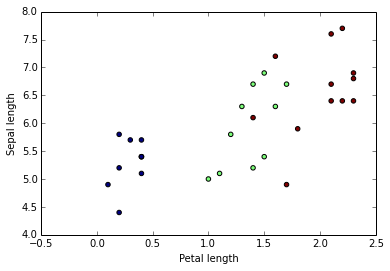

None


In [70]:
let firstTrainFeaturesTransposed = firstTrainFeatures.transposed()
let petalLengths = firstTrainFeaturesTransposed[3].scalars
let sepalLengths = firstTrainFeaturesTransposed[0].scalars

plt.scatter(petalLengths, sepalLengths, c: firstTrainLabels.array.scalars)
plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

## Select the type of model

### Why model?

A *[model](https://developers.google.com/machine-learning/crash-course/glossary#model)* is a relationship between features and the label.  For the iris classification problem, the model defines the relationship between the sepal and petal measurements and the predicted iris species. Some simple models can be described with a few lines of algebra, but complex machine learning models have a large number of parameters that are difficult to summarize.

Could you determine the relationship between the four features and the iris species *without* using machine learning?  That is, could you use traditional programming techniques (for example, a lot of conditional statements) to create a model?  Perhaps—if you analyzed the dataset long enough to determine the relationships between petal and sepal measurements to a particular species. And this becomes difficult—maybe impossible—on more complicated datasets. A good machine learning approach *determines the model for you*. If you feed enough representative examples into the right machine learning model type, the program will figure out the relationships for you.

### Select the model

We need to select the kind of model to train. There are many types of models and picking a good one takes experience. This tutorial uses a neural network to solve the iris classification problem. *[Neural networks](https://developers.google.com/machine-learning/glossary/#neural_network)* can find complex relationships between features and the label. It is a highly-structured graph, organized into one or more *[hidden layers](https://developers.google.com/machine-learning/glossary/#hidden_layer)*. Each hidden layer consists of one or more *[neurons](https://developers.google.com/machine-learning/glossary/#neuron)*. There are several categories of neural networks and this program uses a dense, or *[fully-connected neural network](https://developers.google.com/machine-learning/glossary/#fully_connected_layer)*: the neurons in one layer receive input connections from *every* neuron in the previous layer. For example, Figure 2 illustrates a dense neural network consisting of an input layer, two hidden layers, and an output layer:

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/images/custom_estimators/full_network.png"
         alt="A diagram of the network architecture: Inputs, 2 hidden layers, and outputs">
  </td></tr>
  <tr><td align="center">
    <b>Figure 2.</b> A neural network with features, hidden layers, and predictions.<br/>&nbsp;
  </td></tr>
</table>

When the model from Figure 2 is trained and fed an unlabeled example, it yields three predictions: the likelihood that this flower is the given iris species. This prediction is called *[inference](https://developers.google.com/machine-learning/crash-course/glossary#inference)*. For this example, the sum of the output predictions is 1.0. In Figure 2, this prediction breaks down as: `0.02` for *Iris setosa*, `0.95` for *Iris versicolor*, and `0.03` for *Iris virginica*. This means that the model predicts—with 95% probability—that an unlabeled example flower is an *Iris versicolor*.

### Create a model using Swift abstractions

Swift for TensorFlow doesn't yet have high-level model APIs like Keras, so we will build a model from scratch using low-level TensorFlow APIs.

We also work around some temporary limitations in the compiler:

* You must define the entire model and loss function in a single Jupyter cell in order to train it. This is because Swift's Automatic Differentiation cannot yet take gradients of functions that call functions defined in other Jupyter cells.
* There are a few other workarounds described inline in the comments.

We intend to eliminate these limitations soon.

In [71]:
import TensorFlow

%include "TutorialModelHelpers.swift"

// ==== Define a dense neural network layer ====
// Let's start by defining a dense neural network layer as a Swift `struct`:

struct DenseLayer : ParameterAggregate {
    var w: Tensor<Float>
    var b: Tensor<Float>
    
    init(inputSize: Int32, outputSize: Int32) {
        w = Tensor(glorotUniform: [inputSize, outputSize])
        b = Tensor(zeros: [outputSize])
    }
}

func predictions(for input: Tensor<Float>, using layer: DenseLayer) -> Tensor<Float> {
    return input • layer.w + layer.b
}

// The `ParameterAggregate` in the `DenseLayer` declaration tells Swift that that `DenseLayer` is
// made of parameters that should be updated during training. See the
// [Parameter Update Design](https://github.com/tensorflow/swift/blob/master/proposals/ParameterUpdate.md)
// for more information.

// ==== Define a neural network model ====
// Next, let's use `DenseLayer` to define a nerual network model for the iris classification problem:

let hiddenSize: Int32 = 10

struct IrisParameters : ParameterAggregate {
    var layer1 = DenseLayer(inputSize: 4, outputSize: hiddenSize)
    var layer2 = DenseLayer(inputSize: hiddenSize, outputSize: hiddenSize)
    var layer3 = DenseLayer(inputSize: hiddenSize, outputSize: 3)
}

func predictions(for input: Tensor<Float>, using model: IrisParameters) -> Tensor<Float> {
    let l1 = relu(predictions(for: input, using: model.layer1))
    let l2 = relu(predictions(for: l1, using: model.layer2))
    return predictions(for: l2, using: model.layer3)
}

var model = IrisParameters()

// ==== Define a loss function ====
// See the loss function section later in the tutorial for a description of the loss function.

func loss(for input: Tensor<Float>, using model: IrisParameters, labels: Tensor<Int32>) -> Float {
    let logits = predictions(for: input, using: model)
    return softmaxCrossEntropy(logits: logits, categoricalLabels: labels)
}

// ==== Take the gradient of the loss function ===
// Use Swift's Automatic Differentiation to calculate the
// [*gradients*](https://developers.google.com/machine-learning/glossary/#gradient) used to optimize our model.

func lossAndGradient(for input: Tensor<Float>, 
                     using model: IrisParameters,
                     labels: Tensor<Int32>) -> (Float, IrisParameters) {
    let (loss, (_, modelGrad)) =
        #valueAndGradient(loss(for:using:labels:), wrt: .0, .1)(input, model, labels)
    return (loss, modelGrad)
}

### Using the model

Let's have a quick look at what this model does to a batch of features:

In [72]:
let firstTrainPredictions = predictions(for: firstTrainFeatures, using: model)
firstTrainPredictions[0..<5]

[[-0.29365218, -0.18320385, -0.412854], [-0.18673971, -0.11572692, -0.20553254], [-0.21885929, -0.14516145, -0.33979195], [-0.0934445, -0.09351534, -0.07432554], [-0.10224113, -0.121304244, -0.115348645]]


Here, each example returns a [logit](https://developers.google.com/machine-learning/crash-course/glossary#logits) for each class. 

To convert these logits to a probability for each class, use the [softmax](https://developers.google.com/machine-learning/crash-course/glossary#softmax) function:

In [73]:
softmax(firstTrainPredictions[0..<5])

[[0.05924363, 0.06616203, 0.052586347], [0.0659285, 0.07078051, 0.06470109], [0.06384455, 0.06872748, 0.056572247], [0.072375365, 0.07237024, 0.073772416], [0.0717415, 0.070386834, 0.07080728]]


Taking the `argmax` across classes gives us the predicted class index. But, the model hasn't been trained yet, so these aren't good predictions.

In [74]:
print("Prediction: \(firstTrainPredictions.argmax(squeezingAxis: 1))")
print("    Labels: \(firstTrainLabels)")

Prediction: [1, 1, 1, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1]
    Labels: [2, 1, 2, 0, 0, 0, 0, 2, 1, 0, 1, 1, 0, 0, 2, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 1, 2, 1, 1, 1, 1]


## Train the model

*[Training](https://developers.google.com/machine-learning/crash-course/glossary#training)* is the stage of machine learning when the model is gradually optimized, or the model *learns* the dataset. The goal is to learn enough about the structure of the training dataset to make predictions about unseen data. If you learn *too much* about the training dataset, then the predictions only work for the data it has seen and will not be generalizable. This problem is called *[overfitting](https://developers.google.com/machine-learning/crash-course/glossary#overfitting)*—it's like memorizing the answers instead of understanding how to solve a problem.

The iris classification problem is an example of *[supervised machine learning](https://developers.google.com/machine-learning/glossary/#supervised_machine_learning)*: the model is trained from examples that contain labels. In *[unsupervised machine learning](https://developers.google.com/machine-learning/glossary/#unsupervised_machine_learning)*, the examples don't contain labels. Instead, the model typically finds patterns among the features.

### Define the loss and gradient function

Both training and evaluation stages need to calculate the model's *[loss](https://developers.google.com/machine-learning/crash-course/glossary#loss)*. This measures how off a model's predictions are from the desired label, in other words, how bad the model is performing. We want to minimize, or optimize, this value.

Our model will calculate its loss using the `softmaxCrossEntropy` function which takes the model's class probability predictions and the desired label, and returns the average loss across the examples. See the definition of `loss` in the model section above.

Let's calculate the loss for the current untrained model:

In [75]:
print("Loss test: \(loss(for: firstTrainFeatures, using: model, labels: firstTrainLabels))")

Loss test: 1.112419


### Gradient descent

Gradient descent applies the computed gradients to the model's variables to minimize the `loss` function. You can think of the loss function as a curved surface (see Figure 3) and we want to find its lowest point by walking around. The gradients point in the direction of steepest ascent—so we'll travel the opposite way and move down the hill. By iteratively calculating the loss and gradient for each batch, we'll adjust the model during training. Gradually, the model will find the best combination of weights and bias to minimize loss. And the lower the loss, the better the model's predictions.

<table>
  <tr><td>
    <img src="https://cs231n.github.io/assets/nn3/opt1.gif" width="70%"
         alt="Optimization algorithms visualized over time in 3D space.">
  </td></tr>
  <tr><td align="center">
    <b>Figure 3.</b> Optimization algorithms visualized over time in 3D space. (Source: <a href="http://cs231n.github.io/neural-networks-3/">Stanford class CS231n</a>, MIT License)<br/>&nbsp;
  </td></tr>
</table>

Let's set a learning rate for gradient descent:

In [76]:
let learningRate: Float = 0.001

We'll use this to calculate a single gradient descent step:

In [77]:
let (loss, grads) = lossAndGradient(for: firstTrainFeatures, using: model, labels: firstTrainLabels)
print("Initial Loss: \(loss)")

Initial Loss: 1.112419


We call the `model.update(withGradients:)` method to iterate over all the model parameters and apply gradient descent to them, where `param` is the parameter and where `grad` is the gradient along that parameter.

In [78]:
model.update(withGradients: grads) { param, grad in
    param -= learningRate * grad
}
print("Next Loss: \(loss(for: firstTrainFeatures, using: model, labels: firstTrainLabels))")

Next Loss: 1.1014022


If you run the above two steps repeatedly, you should expect the loss to go down gradually.

### Training loop

With all the pieces in place, the model is ready for training! A training loop feeds the dataset examples into the model to help it make better predictions. The following code block sets up these training steps:

1. Iterate each *epoch*. An epoch is one pass through the dataset.
2. Within an epoch, iterate over each example in the training `Dataset` grabbing its *features* (`x`) and *label* (`y`).
3. Using the example's features, make a prediction and compare it with the label. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
4. Use gradient descent to update the model's variables.
5. Keep track of some stats for visualization.
6. Repeat for each epoch.

The `numEpochs` variable is the number of times to loop over the dataset collection. Counter-intuitively, training a model longer does not guarantee a better model. `numEpochs` is a *[hyperparameter](https://developers.google.com/machine-learning/glossary/#hyperparameter)* that you can tune. Choosing the right number usually requires both experience and experimentation.

In [79]:
let numEpochs = 201
var trainAccuracyResults: [Float] = []
var trainLossResults: [Float] = []

In [80]:
%include "TutorialDatasetCSVAPI.swift"
@inlinable
func trainDataset() -> Dataset<(Tensor<Float>, Tensor<Int32>)> {
    return Dataset(
        contentsOfCSVFile: trainDataFilename, hasHeader: true,
        featureColumns: [0, 1, 2, 3], labelColumns: [4]
    ).batched(batchSize)
}

func accuracy(predictions: Tensor<Int32>, truths: Tensor<Int32>) -> Float {
    return Tensor<Float>(predictions.elementsEqual(truths)).mean()
}

for epoch in 0..<numEpochs {
    var epochLoss: Float = 0
    var epochAccuracy: Float = 0
    var batchCount: Int = 0
    for (x, y) in trainDataset() {       
        let (loss, grad) = lossAndGradient(for: x, using: model, labels: y)
        model.update(withGradients: grad) { $0 -= learningRate * $1 }
        
        let logits = predictions(for: x, using: model)
        epochAccuracy += accuracy(predictions: logits.argmax(squeezingAxis: 1), truths: y)
        epochLoss += loss
        batchCount += 1
    }
    epochAccuracy /= Float(batchCount)
    epochLoss /= Float(batchCount)
    trainAccuracyResults.append(epochAccuracy)
    trainLossResults.append(epochLoss)
    if epoch % 50 == 0 {
        print("Epoch \(epoch): Loss: \(epochLoss), Accuracy: \(epochAccuracy)")
    }
}

Epoch 0: Loss: 1.0988412, Accuracy: 0.30989584
Epoch 50: Loss: 0.37332624, Accuracy: 0.890625
Epoch 100: Loss: 0.20548649, Accuracy: 0.9036458
Epoch 150: Loss: 0.1709755, Accuracy: 0.9348958
Epoch 200: Loss: 0.13892758, Accuracy: 0.9505208


### Visualize the loss function over time

While it's helpful to print out the model's training progress, it's often *more* helpful to see this progress. We can create basic charts using Python's `matplotlib` module.

Interpreting these charts takes some experience, but you really want to see the *loss* go down and the *accuracy* go up.

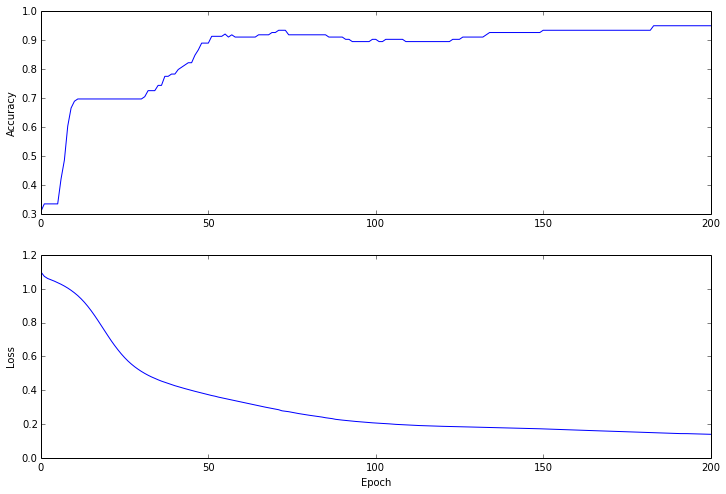

None


In [81]:
plt.figure(figsize: [12, 8])

let accuracyAxes = plt.subplot(2, 1, 1)
accuracyAxes.set_ylabel("Accuracy")
accuracyAxes.plot(trainAccuracyResults)

let lossAxes = plt.subplot(2, 1, 2)
lossAxes.set_ylabel("Loss")
lossAxes.set_xlabel("Epoch")
lossAxes.plot(trainLossResults)

plt.show()

Note that the y-axes of the graphs are not zero-based.

## Evaluate the model's effectiveness

Now that the model is trained, we can get some statistics on its performance.

*Evaluating* means determining how effectively the model makes predictions. To determine the model's effectiveness at iris classification, pass some sepal and petal measurements to the model and ask the model to predict what iris species they represent. Then compare the model's prediction against the actual label.  For example, a model that picked the correct species on half the input examples has an *[accuracy](https://developers.google.com/machine-learning/glossary/#accuracy)* of `0.5`. Figure 4 shows a slightly more effective model, getting 4 out of 5 predictions correct at 80% accuracy:

<table cellpadding="8" border="0">
  <colgroup>
    <col span="4" >
    <col span="1" bgcolor="lightblue">
    <col span="1" bgcolor="lightgreen">
  </colgroup>
  <tr bgcolor="lightgray">
    <th colspan="4">Example features</th>
    <th colspan="1">Label</th>
    <th colspan="1" >Model prediction</th>
  </tr>
  <tr>
    <td>5.9</td><td>3.0</td><td>4.3</td><td>1.5</td><td align="center">1</td><td align="center">1</td>
  </tr>
  <tr>
    <td>6.9</td><td>3.1</td><td>5.4</td><td>2.1</td><td align="center">2</td><td align="center">2</td>
  </tr>
  <tr>
    <td>5.1</td><td>3.3</td><td>1.7</td><td>0.5</td><td align="center">0</td><td align="center">0</td>
  </tr>
  <tr>
    <td>6.0</td> <td>3.4</td> <td>4.5</td> <td>1.6</td> <td align="center">1</td><td align="center" bgcolor="red">2</td>
  </tr>
  <tr>
    <td>5.5</td><td>2.5</td><td>4.0</td><td>1.3</td><td align="center">1</td><td align="center">1</td>
  </tr>
  <tr><td align="center" colspan="6">
    <b>Figure 4.</b> An iris classifier that is 80% accurate.<br/>&nbsp;
  </td></tr>
</table>

### Setup the test dataset

Evaluating the model is similar to training the model. The biggest difference is the examples come from a separate *[test set](https://developers.google.com/machine-learning/crash-course/glossary#test_set)* rather than the training set. To fairly assess a model's effectiveness, the examples used to evaluate a model must be different from the examples used to train the model.

The setup for the test `Dataset` is similar to the setup for training `Dataset`. Download the test set from http://download.tensorflow.org/data/iris_training.csv:

In [82]:
let urllib = Python.import("urllib")
let downloadResult = urllib.urlretrieve("http://download.tensorflow.org/data/iris_test.csv",
                                        "iris_test.csv")
let testDataFilename = String(downloadResult[0])!
testDataFilename

"iris_test.csv"


 Now load it into a `Dataset`:

In [83]:
%include "TutorialDatasetCSVAPI.swift"
@inlinable
func testDataset() -> Dataset<(Tensor<Float>, Tensor<Int32>)> {
    return Dataset(
        contentsOfCSVFile: testDataFilename, hasHeader: true,
        featureColumns: [0, 1, 2, 3], labelColumns: [4]
    ).batched(batchSize)
}

### Evaluate the model on the test dataset

Unlike the training stage, the model only evaluates a single [epoch](https://developers.google.com/machine-learning/glossary/#epoch) of the test data. In the following code cell, we iterate over each example in the test set and compare the model's prediction against the actual label. This is used to measure the model's accuracy across the entire test set.

In [84]:
%include "TutorialDatasetCSVAPI.swift"
@inlinable
func testDataset() -> Dataset<(Tensor<Float>, Tensor<Int32>)> {
    return Dataset(
        contentsOfCSVFile: testDataFilename, hasHeader: true,
        featureColumns: [0, 1, 2, 3], labelColumns: [4]
    ).batched(batchSize)
}

// NOTE: With `batchSize = 32` and 30 examples in the test dataset, only one batch will run in the loop.
for (testFeatures, testLabels) in testDataset() {
    let logits = predictions(for: testFeatures, using: model)
    let predictions = logits.argmax(squeezingAxis: 1)
    print("Test batch accuracy: \(accuracy(predictions: predictions, truths: testLabels))")
}

Test batch accuracy: 0.93333334


We can see on the first batch, for example, the model is usually correct:

In [85]:
%include "TutorialDatasetCSVAPI.swift"
@inlinable
func testDataset() -> Dataset<(Tensor<Float>, Tensor<Int32>)> {
    return Dataset(
        contentsOfCSVFile: testDataFilename, hasHeader: true,
        featureColumns: [0, 1, 2, 3], labelColumns: [4]
    ).batched(batchSize)
}

let (firstTestBatchFeatures, firstTestBatchLabels) = testDataset().first()!
let firstTestBatchLogits = predictions(for: firstTestBatchFeatures, using: model)
let firstTestBatchPredictions = firstTestBatchLogits.argmax(squeezingAxis: 1)

print(firstTestBatchPredictions)
print(firstTestBatchLabels)

[1, 1, 0, 1, 1, 1, 0, 1, 1, 2, 2, 0, 2, 1, 1, 0, 1, 0, 0, 2, 0, 1, 2, 1, 1, 1, 0, 1, 2, 1]
[1, 2, 0, 1, 1, 1, 0, 2, 1, 2, 2, 0, 2, 1, 1, 0, 1, 0, 0, 2, 0, 1, 2, 1, 1, 1, 0, 1, 2, 1]


## Use the trained model to make predictions

We've trained a model and demonstrated that it's good—but not perfect—at classifying iris species. Now let's use the trained model to make some predictions on [unlabeled examples](https://developers.google.com/machine-learning/glossary/#unlabeled_example); that is, on examples that contain features but not a label.

In real-life, the unlabeled examples could come from lots of different sources including apps, CSV files, and data feeds. For now, we're going to manually provide three unlabeled examples to predict their labels. Recall, the label numbers are mapped to a named representation as:

* `0`: Iris setosa
* `1`: Iris versicolor
* `2`: Iris virginica

In [86]:
let unlabeledDataset: Tensor<Float> =
    [[5.1, 3.3, 1.7, 0.5],
     [5.9, 3.0, 4.2, 1.5],
     [6.9, 3.1, 5.4, 2.1]]

let unlabeledDatasetPredictions = predictions(for: unlabeledDataset, using: model)

for i in 0..<unlabeledDatasetPredictions.shape[0] {
    let logits = unlabeledDatasetPredictions[i]
    let classIdx = logits.argmax()
    print("Example \(i) prediction: \(classNames[Int(classIdx)]) (\(softmax(logits)))")
}

Example 0 prediction: Iris setosa ([0.9949138, 0.0050862175, 1.0199701e-10])
Example 1 prediction: Iris versicolor ([0.0020328988, 0.9914481, 0.0065190336])
Example 2 prediction: Iris versicolor ([6.32724e-06, 0.58730626, 0.41268736])
